#  Model PEPS
The notebook below shows the variational circuit. We present a binary classifier based on articles:

* ["Supervised Learning with Projected Entangled Pair States" discusses the application of projected entangled pair states (PEPS)"](https://arxiv.org/abs/2009.09932)
* [A practical introduction to tensor networks: Matrix product states and projected entangled pair states](https://www.sciencedirect.com/science/article/pii/S0003491614001596)

We're utilizing PCA for dimensionality reduction. We also conducted experiments for a 6-class classification task, adjusting the metrics accordingly. In the future, it would be beneficial to further explore this architecture by tuning hyperparameters, experimenting with different cost functions, and considering alternative dimensionality reduction techniques.

We initially used only the `cross-entropy` cost function, but the code is designed to easily switch to other cost functions, such as the `average exponential` cost function or the `average focal` cost function, both of which are available in the 'training.py' file.

<a id="0"></a> <br>
1. [Data Preparation](#1)
2. [Model](#2)
3. [Experiment 1 - 2 classes](#3)
4. [Experiment 2 - 2 classes](#4)

Parameters:
* corpping - `vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75`
* image size to resize - `(64, 64)`
* PCA components - `256`
* Split data to train and validation - `train_ratio=0.8`
* cost functino - cross entropy 



| Experiment | Class | Training set         | Validation set       | Test set             | Cost function      | Epoch | Batch | Learning rate | Training time | Val_accuracy | Test_accuracy |
|------------|-----| ------------------|----------------------|----------------------|--------------------|-------|-------|----------------|---------------|--------------|---------------|
| 1     | 2     | [138 141] | [20 21]  | [42 38] | Cross-Entropy Loss | 200    | 64    | 0.1           | 0.5 h         | 92.68%        | 76%           |
| 2     | 2   | [138 141] | [20 21]  | [42 38] | Cross-Entropy Loss | 300   | 128   | 0.1           | 1 h           | 85.37%       | 80%         |
| -     | 6    | [331 331 315 310 320 317] | - | [70 70 86 91 81 84] | Cross-Entropy Loss | 50   | -    | 0.1           | 2 h         | -          | 47.51%        |
| -     | 6    | [78 78 88 81 78 81] | - | [23 23 13 20 23 20] | Cross-Entropy Loss | 50   | -    | 0.1           |  -       | -         | 63.11%        |

For the experiments we calculate also another metrics:Precision,Recall,F1 Score,Balanced Accuracy, AUC-ROC, confusion matrix.

Experiments for the 6-class classification are not included here; we only provide a summary of the results.

<a id="1"></a> <br>
### Data Preparation


Initialize the ImageLoader to load and preprocess data.
Below, we load up to 100 images per label, applies cropping with specified parameters to focus on relevant image regions, and resizes each image to 64x64 pixels for consistency.

Cropping parameters: `vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75`.
Image size to resize: `(64, 64)`

In [1]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader(['./Data_Sources/al5083/train'], ['./Data_Sources/al5083/train/train.json'], (64, 64))
all_data = loader.load_images(image_limit=200,vertical_start_split=0.3, vertical_end_split=1.0,
                              horizontal_start_split=0.25, horizontal_end_split=0.75)

Images loaded: 1200, Current label: 5, Total per label: {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200}

Total images loaded : 1200


Create a balanced dataset for binary classification, where Class 1 consists of five different types of defective images.

In [2]:
from Modules.Utils import reduce_dataset_to_2_classes
binary_all_data = reduce_dataset_to_2_classes(all_data, class_0_count=200, other_classes_count=40)

Shuffles the dataset, flattens the image data arrays, scales the flattened features, and separates them into features and labels. Applies PCA to reduce the dimensionality of the given dataset to components = `256`

In [3]:
from  Modules.Utils import prepare_data
from Modules.Utils import apply_pca

X_set,Y_set = prepare_data(binary_all_data)
X_reduced = apply_pca(X_set, n_components=256)

Split train data to train set and validation set. `train_ratio=0.8`

In [4]:
from Modules.Utils import split_data_into_train_val_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data_into_train_val_test(X = X_reduced, Y = Y_set, train_ratio=0.7, val_ratio=0.1,test_ratio=0.2)

Y_train: Values: [0 1] Counts: [138 141]
Y_val: Values: [0 1] Counts: [20 21]
Y_test: Values: [0 1] Counts: [42 38]


<a id="2"></a> <br>
### Model
While developing the model, we used:
* ["Supervised Learning with Projected Entangled Pair States"](https://arxiv.org/abs/2009.09932) discusses the application of projected entangled pair states (PEPS) in constructing supervised learning models, particularly for image data.
* [A practical introduction to tensor networks: Matrix product states and projected entangled pair states](https://www.sciencedirect.com/science/article/pii/S0003491614001596)

tensor([[0.54971074, 0.45028926]], requires_grad=True)

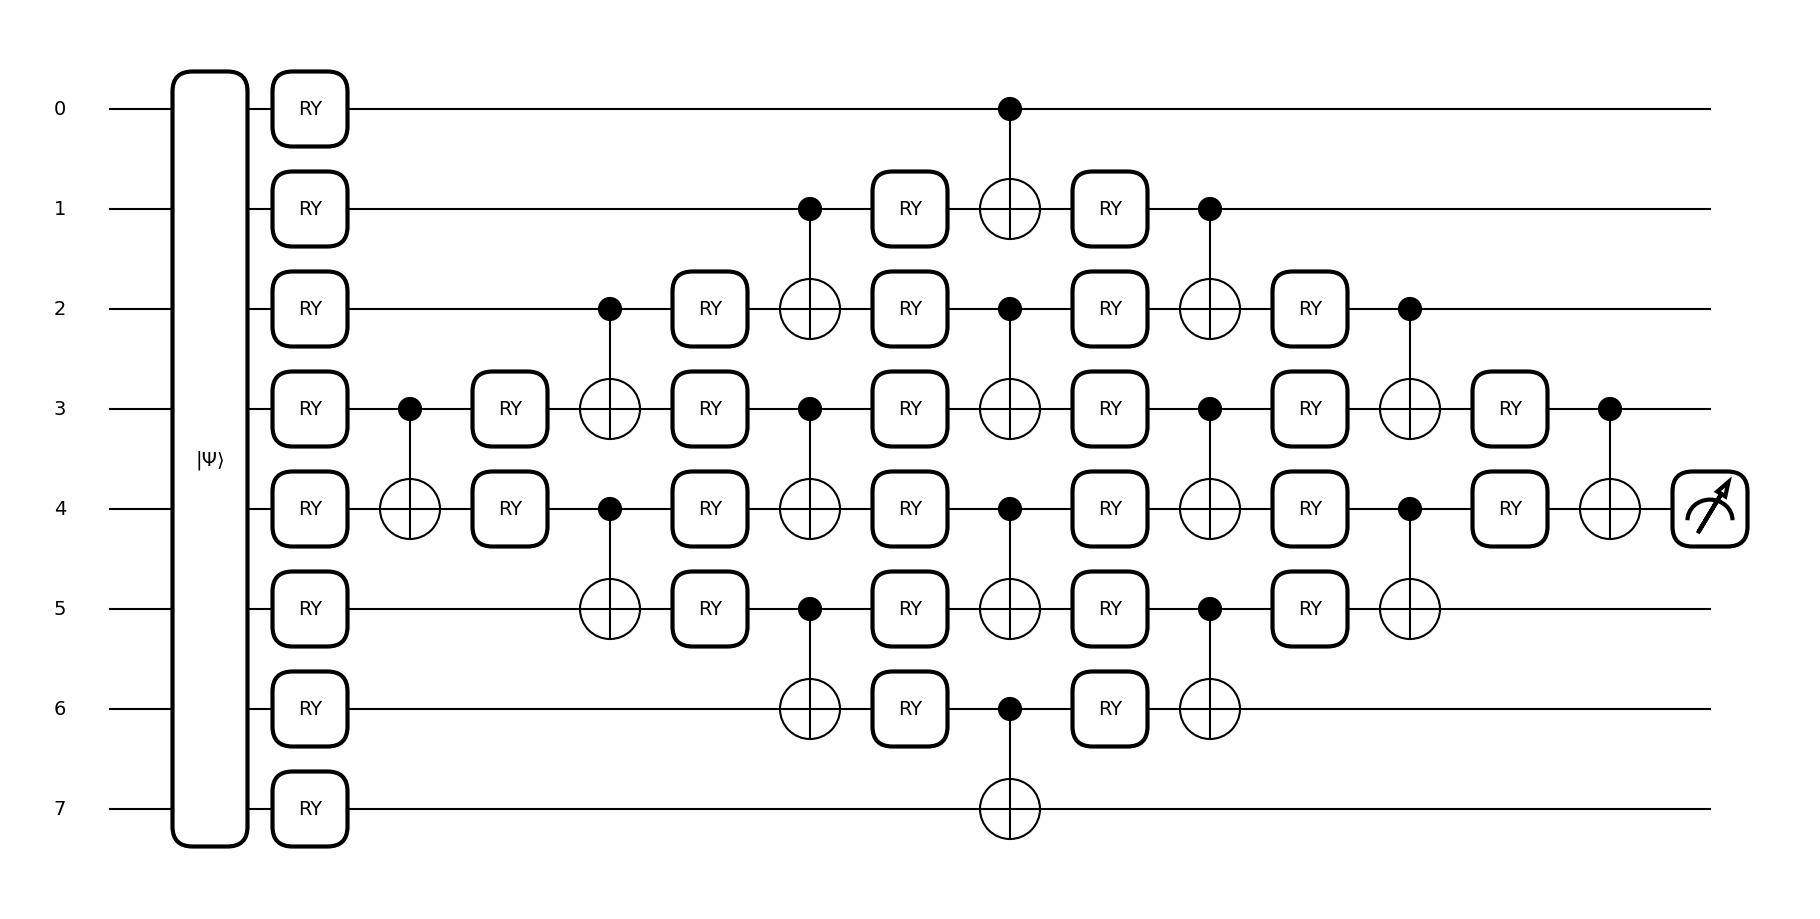

In [5]:
import pennylane as qml
from pennylane import numpy as np
dev = qml.device("default.qubit", wires=8)

@qml.qnode(dev)
def circuit_peps(image, template_weights):
    qml.AmplitudeEmbedding(features=image, wires=range(8), normalize=True)

    i = 0

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(0, 7, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    return qml.probs(wires = [4])

weights = np.random.random(size=[32, 1])
qml.draw_mpl(circuit_peps, expansion_strategy="device")(X_train[0], weights)
circuit_peps(X_train[0], weights)

<a id="3"></a> <br>
### Experiment 1 - 2 classes
In this section, we perform the training process of the above model. Below, we see the cross entropy cost function. We use the following hyperparameters for training:
* `qml.AdamOptimizer(stepsize=0.1)`
* `batch_size = 64`
* `num_epoch = 300`

In [8]:
# training the circuit parameters
from pennylane import numpy as np
params = np.random.random(size=[32, 1], requires_grad=True)
optimizer = qml.AdamOptimizer(stepsize=0.1)
batch_size = 64
num_epoch = 300

In [9]:
from Modules.training import train_model
import time

start_time = time.time()
all_params, train_accuracies, val_accuracies, costs = train_model(X_train, Y_train, X_val, Y_val, params, optimizer, circuit_peps, 2, num_epoch, batch_size)
print("--- %hr --- %", (time.time() - start_time)/3600)

Epoch: 1 | Cost: 0.6502614 | Acc train: 0.6875000 | Acc validation: 0.4878049
Epoch: 2 | Cost: 0.6146321 | Acc train: 0.6562500 | Acc validation: 0.4878049
Epoch: 3 | Cost: 0.6100793 | Acc train: 0.6718750 | Acc validation: 0.5365854
Epoch: 4 | Cost: 0.6552310 | Acc train: 0.6406250 | Acc validation: 0.4878049
Epoch: 5 | Cost: 0.6345756 | Acc train: 0.6406250 | Acc validation: 0.5121951
Epoch: 6 | Cost: 0.6142550 | Acc train: 0.7812500 | Acc validation: 0.5121951
Epoch: 7 | Cost: 0.6486786 | Acc train: 0.6562500 | Acc validation: 0.5609756
Epoch: 8 | Cost: 0.6345118 | Acc train: 0.6875000 | Acc validation: 0.5853659
Epoch: 9 | Cost: 0.6262589 | Acc train: 0.6875000 | Acc validation: 0.5853659
Epoch: 10 | Cost: 0.6259838 | Acc train: 0.6562500 | Acc validation: 0.6341463
Epoch: 11 | Cost: 0.6437239 | Acc train: 0.6718750 | Acc validation: 0.6341463
Epoch: 12 | Cost: 0.5867757 | Acc train: 0.7031250 | Acc validation: 0.6585366
Epoch: 13 | Cost: 0.6231945 | Acc train: 0.7343750 | Acc vali

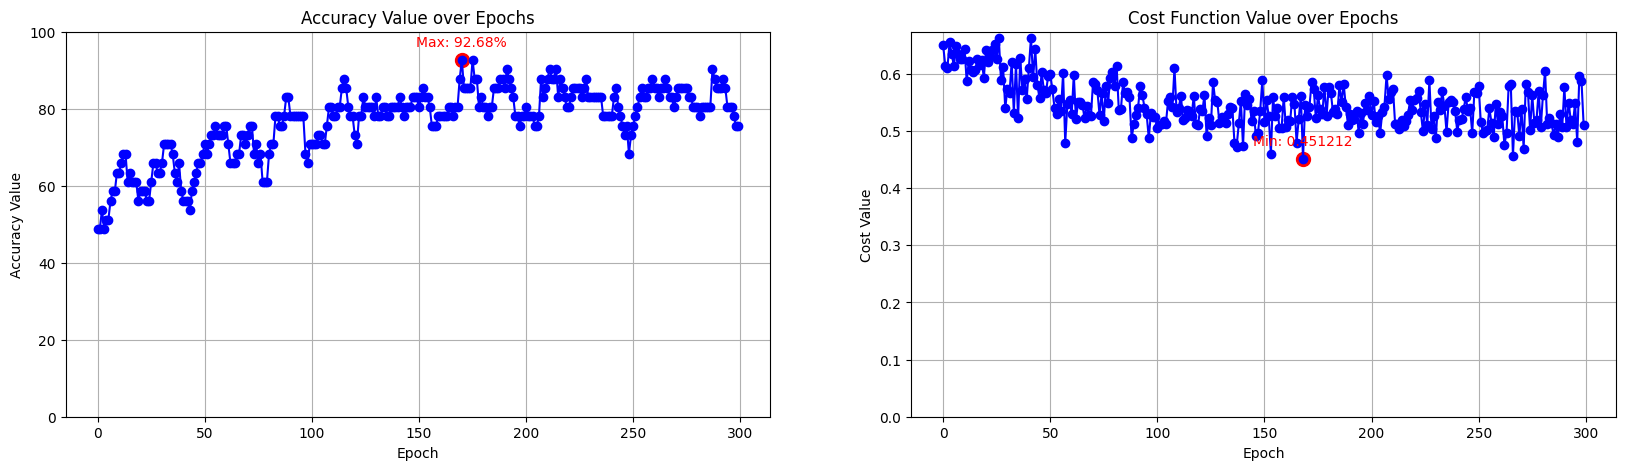

In [15]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(val_accuracies,costs)

In the cell below, we evaluate the model using different sets of parameters. We use the parameters corresponding to the minimum cost function value, the maximum validation set accuracy, and the final parameters returned at the end of the training process.
Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

In [16]:
from Modules.metrices import accuracy
# Find the parameters that give the minimum cost
params_min_costs = all_params[np.argmin(costs)]
test_accuracy_min_costs = accuracy(params_min_costs, X_test, Y_test, circuit_peps)

# Find the parameters that give the maximum validation accuracy
params_max_val_accuracy = all_params[np.argmax(val_accuracies)]
test_accuracy_max = accuracy(params_max_val_accuracy, X_test, Y_test, circuit_peps)

# Calculate test accuracy for the final parameters after the last epoch
test_accuracy_final = accuracy(all_params[-1], X_test, Y_test, circuit_peps)

print(f"Test Accuracy with params giving minimum cost: {test_accuracy_min_costs:.4f}")
print(f"Test Accuracy with params giving maximum validation accuracy: {test_accuracy_max:.4f}")
print(f"Test Accuracy with final parameters: {test_accuracy_final:.4f}")

Test Accuracy with params giving minimum cost: 0.7750
Test Accuracy with params giving maximum validation accuracy: 0.7500
Test Accuracy with final parameters: 0.7125


We take params for minimum cost function value. This params is saved as '02_Peps_binary_Exp1.txt' in experiment output.

Test Accuracy with params giving minimum cost: 0.7750
Accuracy: 0.7750 | Precision: 0.8125 | Recall: 0.6842 | F1 Score: 0.7429 | AUC-ROC: 0.7707 | Balanced Accuracy: 0.7707
              precision    recall  f1-score   support

     class 0       0.75      0.86      0.80        42
     class 1       0.81      0.68      0.74        38

    accuracy                           0.78        80
   macro avg       0.78      0.77      0.77        80
weighted avg       0.78      0.78      0.77        80



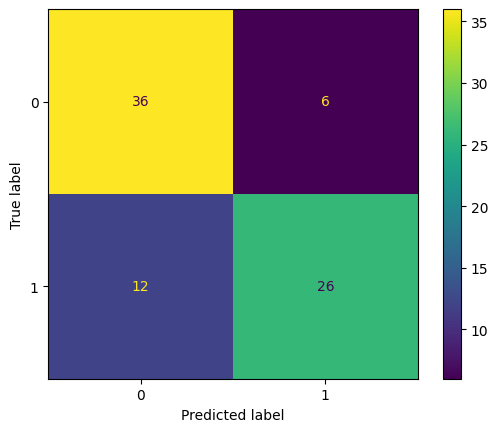

In [17]:
from Modules.metrices import accuracy
test_accuracy_min_costs = accuracy(params_min_costs, X_test, Y_test, circuit_peps)
print(f"Test Accuracy with params giving minimum cost: {test_accuracy_min_costs:.4f}")
from Modules.metrices import show_all_metrics

show_all_metrics(params_min_costs, X_test, Y_test, circuit_peps)

<a id="4"></a> <br>
### Experiment 2 - 2 classes
In this section, we perform the training process of the above model. Below, we see the cross entropy cost function. We use the following hyperparameters for training:
*`qml.AdamOptimizer(stepsize=0.1)`
* `batch_size = 128`
* `num_epoch = 300`

In [ ]:
from Modules.training import train_model
import time
# training the circuit parameters
from pennylane import numpy as np
params = np.random.random(size=[32, 1], requires_grad=True)
optimizer = qml.AdamOptimizer(stepsize=0.1)
batch_size = 128
num_epoch = 300

start_time = time.time()
all_params, train_accuracies, val_accuracies, costs = train_model(X_train, Y_train, X_val, Y_val, params, optimizer, circuit_peps, 2, num_epoch, batch_size)
print("--- %hr --- %", (time.time() - start_time)/3600)

Epoch: 1 | Cost: 0.6936306 | Acc train: 0.5703125 | Acc validation: 0.4634146
Epoch: 2 | Cost: 0.6651585 | Acc train: 0.6328125 | Acc validation: 0.5853659
Epoch: 3 | Cost: 0.6737893 | Acc train: 0.5859375 | Acc validation: 0.5853659
Epoch: 4 | Cost: 0.6388936 | Acc train: 0.6718750 | Acc validation: 0.6097561
Epoch: 5 | Cost: 0.6338777 | Acc train: 0.6796875 | Acc validation: 0.5609756
Epoch: 6 | Cost: 0.6411513 | Acc train: 0.6562500 | Acc validation: 0.6829268
Epoch: 7 | Cost: 0.6153372 | Acc train: 0.7187500 | Acc validation: 0.6585366
Epoch: 8 | Cost: 0.6449714 | Acc train: 0.6953125 | Acc validation: 0.7073171
Epoch: 9 | Cost: 0.6062805 | Acc train: 0.7031250 | Acc validation: 0.6585366
Epoch: 10 | Cost: 0.5930689 | Acc train: 0.7500000 | Acc validation: 0.6829268
Epoch: 11 | Cost: 0.5990798 | Acc train: 0.7500000 | Acc validation: 0.7073171
Epoch: 12 | Cost: 0.5772675 | Acc train: 0.8046875 | Acc validation: 0.7317073
Epoch: 13 | Cost: 0.5770866 | Acc train: 0.7812500 | Acc vali

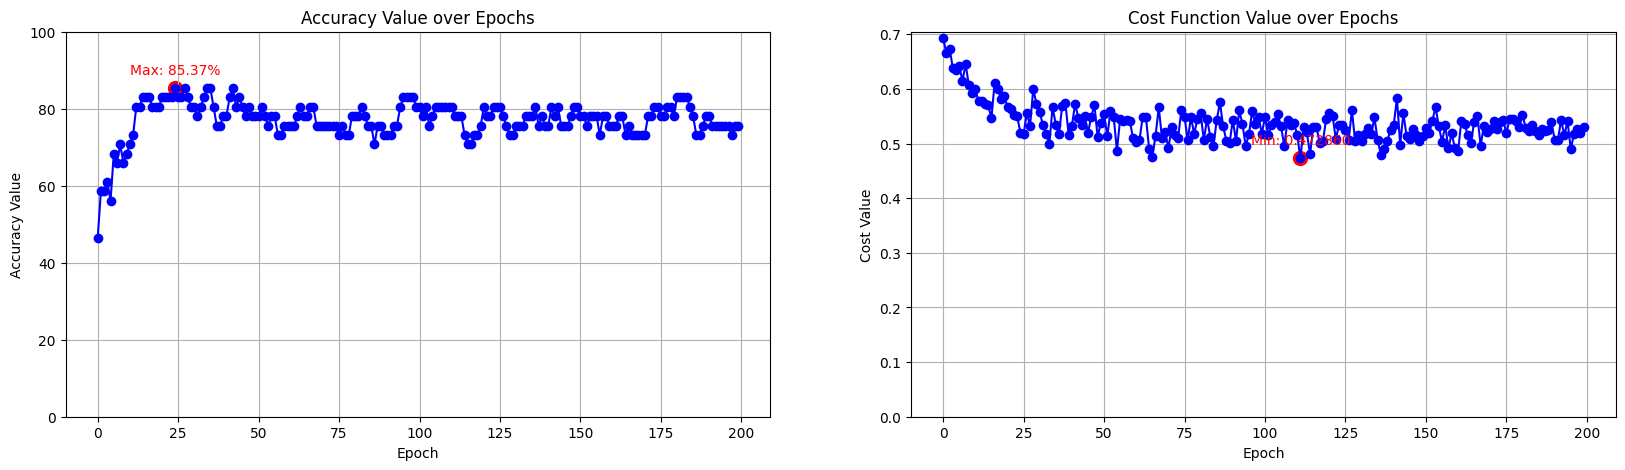

In [5]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(val_accuracies,costs)

In [2]:
from Modules.metrices import accuracy
# Find the parameters that give the minimum cost
params_min_costs = all_params[np.argmin(costs)]
test_accuracy_min_costs = accuracy(params_min_costs, X_test, Y_test, circuit_peps)

# Find the parameters that give the maximum validation accuracy
params_max_val_accuracy = all_params[np.argmax(val_accuracies)]
test_accuracy_max = accuracy(params_max_val_accuracy, X_test, Y_test, circuit_peps)

# Calculate test accuracy for the final parameters after the last epoch
test_accuracy_final = accuracy(all_params[-1], X_test, Y_test, circuit_peps)

print(f"Test Accuracy with params giving minimum cost: {test_accuracy_min_costs:.4f}")
print(f"Test Accuracy with params giving maximum validation accuracy: {test_accuracy_max:.4f}")
print(f"Test Accuracy with final parameters: {test_accuracy_final:.4f}")

Test Accuracy with params giving minimum cost: 80%
Test Accuracy with params giving maximum validation accuracy: 74.35%
Test Accuracy with final parameters: 77.47%


In [ ]:
from Modules.metrices import accuracy
test_accuracy_min_costs = accuracy(params_min_costs, X_test, Y_test, circuit_peps)
print(f"Test Accuracy with params giving minimum cost: {test_accuracy_min_costs:.4f}")
from Modules.metrices import show_all_metrics

show_all_metrics(params_min_costs, X_test, Y_test, circuit_peps)